# Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:65468")

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import numpy as np
import xarray as xr
import scipy
import dask
import gsw
import eos_module
import matplotlib.pyplot as plt

# Downsampling function

Coarsening by averaging over a 2D window with weights defined by area

In [4]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    # threshold = 0.0
    # new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    # result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # #apply new mask to data
    # result = result.where(result.tmask>0)
    return result

In [5]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

# Data read

In [6]:
data=[dict() for i in range(4)]
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GS FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GS ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})

In [7]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,1),y=y_slice,x=x_slice)  
coord_slice = dict(y=y_slice,x=x_slice)

In [8]:
nb_of_time_chunks = 7

In [9]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    data[i]['HR'] = current_set

CPU times: user 837 ms, sys: 1.77 s, total: 2.61 s
Wall time: 17.8 s


# Compute true density

In [10]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 4.81 s, sys: 6.55 s, total: 11.4 s
Wall time: 19.3 s


# Apply filter

In [11]:
filter_size=0. # no filter
coarsening_window_size = 15 # to match eORCA025 resolution

In [12]:
%%time
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = apply_filter_downsample(data[i]['HR'], filter_size, coarsening_window_size).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    data[i]['HR_Filtered'].attrs['coarsening_window_size'] = coarsening_window_size
    data[i]['HR_Filtered'].attrs['gaussian_filter_size'] = filter_size

CPU times: user 31.6 s, sys: 30.8 s, total: 1min 2s
Wall time: 1min 30s


# Compute the subgrid variance and density error

In [13]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_Filtered']
    # subgrid temp variance
    ds['var_T'] = ds['sst_sqr'] - ds['sosstsst']**2
    ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
    # density correction
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 182 ms, sys: 78.9 ms, total: 261 ms
Wall time: 831 ms


# Compute density derivatives

In [14]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered']] :
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['sosstsst'])

CPU times: user 36.7 s, sys: 1min 28s, total: 2min 5s
Wall time: 2min 27s


# Select points in space

In [15]:
x_slice = slice(-21,-1)
y_slice = slice(-21,-1)

data_slice = dict(y=y_slice,x=x_slice)  # take every 50-th hourly output

In [16]:
for i in range(len(data)) :
    data[i]['HR_Filtered'] = data[i]['HR_Filtered'][data_slice]

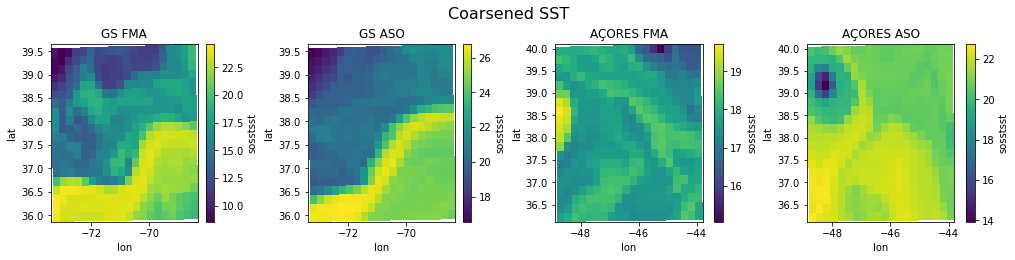

In [17]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.5*len(data),3.5), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('Coarsened SST', size=16)
for i in range(len(data)) :
    data[i]['HR_Filtered'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[i])
    axis[i].set(title=data[i]['label'])

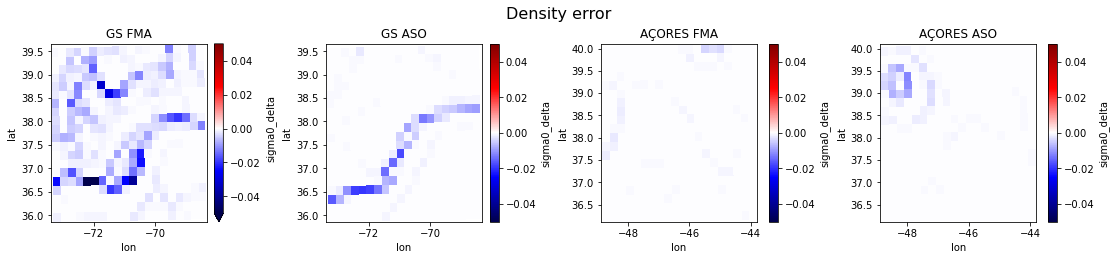

In [18]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.85*len(data),3.5), constrained_layout=True)
quantity='sigma0_delta'
fig.suptitle('Density error', size=16)
for i in range(len(data)) :
    data[i]['HR_Filtered'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[i], cmap='seismic', vmax=0.05, vmin=-0.05)
    axis[i].set(title=data[i]['label'])

In [19]:
for i in range(len(data)) :
    data[i]['HR_Filtered'].coords['x'] = np.arange(len(data[i]['HR_Filtered'].coords['x']))
    data[i]['HR_Filtered'].coords['y'] = np.arange(len(data[i]['HR_Filtered'].coords['y']))

# Write dataset

In [20]:
# drop useless variables and coordiantes
for i in range(len(data)) :
    data[i]['HR_Filtered'] = data[i]['HR_Filtered'].drop(['time_centered', 'tmask', 'nav_lat', 'nav_lon', 'depth', 'e1f', 'e2f', 'e1u', 'e2u', 'e1v', 'e2v', 'e1t', 'e2t', 'sigma0_model', 'sigma0_true', 'sst_sqr', 'sal_sqr'], errors='ignore')
    data[i]['HR_Filtered'].attrs['label'] = data[i]['label']

In [21]:
# # pandas format
# for i in range(len(data)) :
#     for it, counter in enumerate(data[i]['HR_Filtered']['time_counter']) :
#         (data[i]['HR_Filtered'].isel(time_counter=it).drop('time_counter')).to_dataframe().to_csv("datasets/dataset"+str(i)+"_it"+str(it)+".csv")

In [22]:
# netcdf format
for i in range(len(data)) :
    data[i]['HR_Filtered'].to_netcdf("datasets/dataset"+str(i)+".nc")

In [23]:
len(data[i]['HR_Filtered']['time_counter'])

367

In [24]:
index_table = np.transpose(np.stack([np.concatenate([np.full(len(data[i]['HR']['time_counter']), i) for i in range(len(data))]),\
         np.concatenate([np.arange(len(data[i]['HR']['time_counter'])) for i in range(len(data))])]))

In [25]:
index_table.shape

(1444, 2)

In [26]:
data[i]['HR_Filtered'].coords['time_counter']

<xarray.DataArray 'time_counter' (time_counter: 367)>
array(['2009-08-01T00:30:00.000000000', '2009-08-01T06:30:00.000000000',
       '2009-08-01T12:30:00.000000000', ..., '2009-10-31T00:30:00.000000000',
       '2009-10-31T06:30:00.000000000', '2009-10-31T12:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...